# LeNet
The architecture is roughly based on LeNet-5.
max instead of average pooling

In [1]:
%pip install --upgrade matplotlib      # to make subfigures work on Colab. You'll have to restart runtime afterward.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 24.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [2]:
import torch
from torchvision import datasets
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from IPython import display
import numpy as np

# display plots inline (in the notebook rather than another window)
%matplotlib inline

#plt.rcParams['image.cmap'] = 'gray'

plt.rcParams['image.cmap'] = 'hot'

torch.manual_seed(485)        # manually seed the random number generator (useful if you want reproducible experiments)

In [3]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()   # floating point, normalized to range [0, 1]
)

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 114381760.98it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24457034.89it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31311194.50it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4006420.35it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
# visualization functions
def montage(fig, imgstack):
    nimg = imgstack.size(dim = 0)
    width = int(np.ceil(np.sqrt(nimg)))   # compute a roughly square layout for the panels
    height = int(np.ceil(nimg / width))
    for i in range(nimg):
        ax = fig.add_subplot(height, width, i+1)
        ax.matshow(imgstack[i])
        ax.axis('off')

def movingaverage(arr, windowsize):
    return np.pad(np.convolve(arr, np.ones(windowsize)/windowsize, mode ='valid'), (windowsize-1, 0))

def viz(fig, kernels, fmaps1, fmaps2, entropy, errcl):
    subfigs = fig.subfigures(2, 2, wspace=0.07)
    montage(subfigs[0, 0], kernels)
    subfigs[0, 0].suptitle('kernels')
    montage(subfigs[1, 0], fmaps1)
    subfigs[1, 0].suptitle('feature maps')
    montage(subfigs[1, 1], fmaps2)
    subfigs[1, 1].suptitle('feature maps')
    subfigs[0, 1].add_subplot(1, 1, 1)
    plt.plot(entropy, label='loss')
    plt.plot(movingaverage(errcl, 50), label='class error')
    plt.legend()
    plt.yscale("log")
    display.clear_output(wait=True)
    display.display(fig)
    fig.clf()

In [5]:
ignore, nrow, ncol = training_data.data.size()
nclass = len(torch.unique(training_data.targets))    # number of classes

tmax = 100000

errcl = torch.zeros(tmax)    # classification error vs. time
entropy = torch.zeros(tmax)   # cross entropy loss vs. time

tshow = 1000   # how often to pause and plot
eta = 0.1  # learning rate parameter (controls length of gradient step)

In [6]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 5, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(-3),
    nn.Linear(400, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
    )

In [7]:
# A simple hook class that returns the input and output of a layer during forward/backward pass
# https://www.kaggle.com/code/sironghuang/understanding-pytorch-hooks
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_full_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [8]:
h2 = Hook(model[2])
h5 = Hook(model[5])

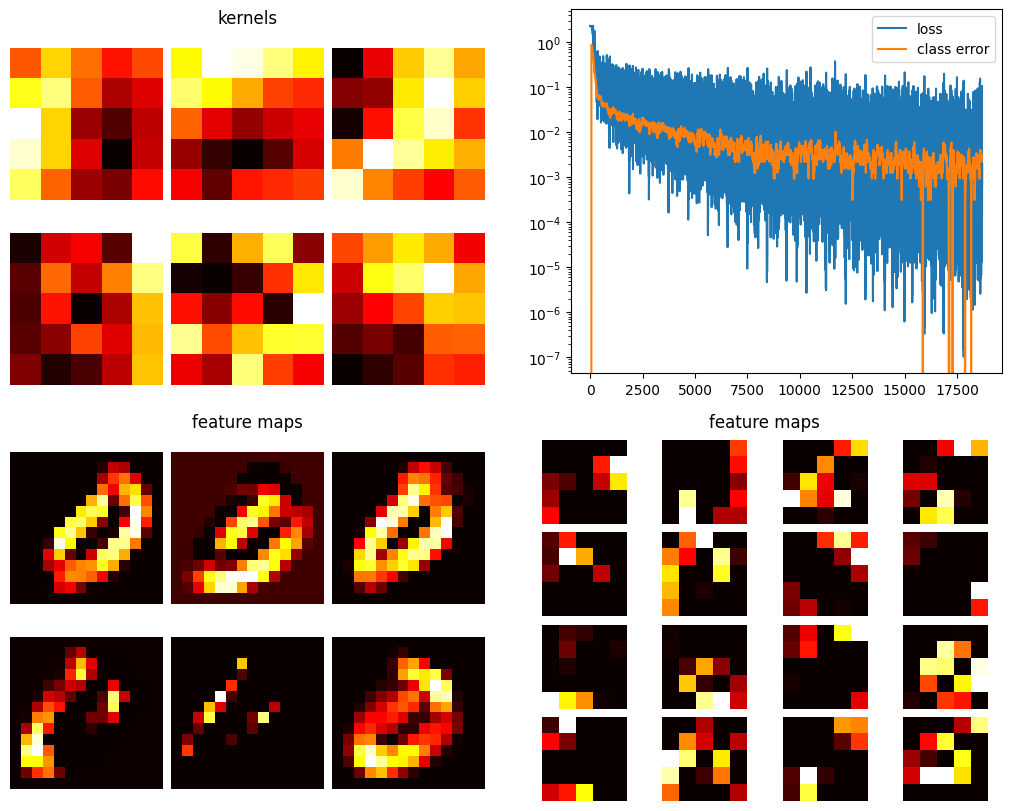

<Figure size 1000x800 with 0 Axes>

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(10, 8))

t = 0
nepoch = 20

for epoch in range(nepoch):
    for (X, y) in iter(train_dataloader):
        logit = model(X)

        desired = F.one_hot(y, 10).float()
        loss = F.cross_entropy(logit, desired)
        loss.backward()

        with torch.no_grad():
            errcl[t] = torch.mean((torch.max(logit, 1).indices != y).float())
            entropy[t] = loss
            for p in model.parameters():
               p -= p.grad * eta
               p.grad.zero_()

        if (t+1) % 100 == 0:
            print(entropy[t])
            viz(fig, model[0].weight.detach().view(6, 5, 5), h2.output[1].detach(), h5.output[1].detach(), entropy[:t], errcl[:t])
        t += 1